<a href="https://githubtocolab.com/AndresBanquezBio/Hackathon/blob/main/Modelos_General.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Descarga de datos y su concatenación

Elegir el método de su preferencia

In [ ]:
!wget https://raw.githubusercontent.com/AndresBanquezBio/Hackathon/main/dataEncode.csv 
! unzip Dataset.zip

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve,train_test_split,cross_validate, ShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,average_precision_score,mean_absolute_error,r2_score,confusion_matrix,classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import LinearSVC
import textwrap
from sklearn.decomposition import NMF,PCA
from itertools import product
import joblib

In [4]:
dataset=pd.read_csv("dataEncode.csv")

In [5]:
dataset

,DiasEstanciaClinica_exactoLog,DiasEstanciaServicio,Antioboticos,Transfusiones,UCI_UCE,ClasificacionCronico_DX_pre_cx,DX_pos_cx,ClasificacionCronico_DX_pos_cx,DX_pre_cx,DX_R3
0,0.047392,1,0,0,0,1,0,1,0,1721
1,1.372036,4,0,0,0,1,0,1,0,769
2,0.584829,1,1,0,0,1,0,1,0,794
3,0.941894,1,1,0,0,1,0,1,0,769
4,1.702274,4,0,0,0,1,0,1,0,1858
...,...,...,...,...,...,...,...,...,...,...
43149,0.942048,2,0,0,0,1,0,1,0,1784
43150,0.608355,1,0,0,0,1,0,1,0,496
43151,0.015271,1,0,0,0,1,0,1,0,1640
43152,0.459314,1,1,0,0,0,1217,0,1180,0


## 0.1 Ajuste del dataset

Debido a la gran cantidad de datos vamos a recortarlos para tener una mejor cantidad para no aumentar el gasto computacional

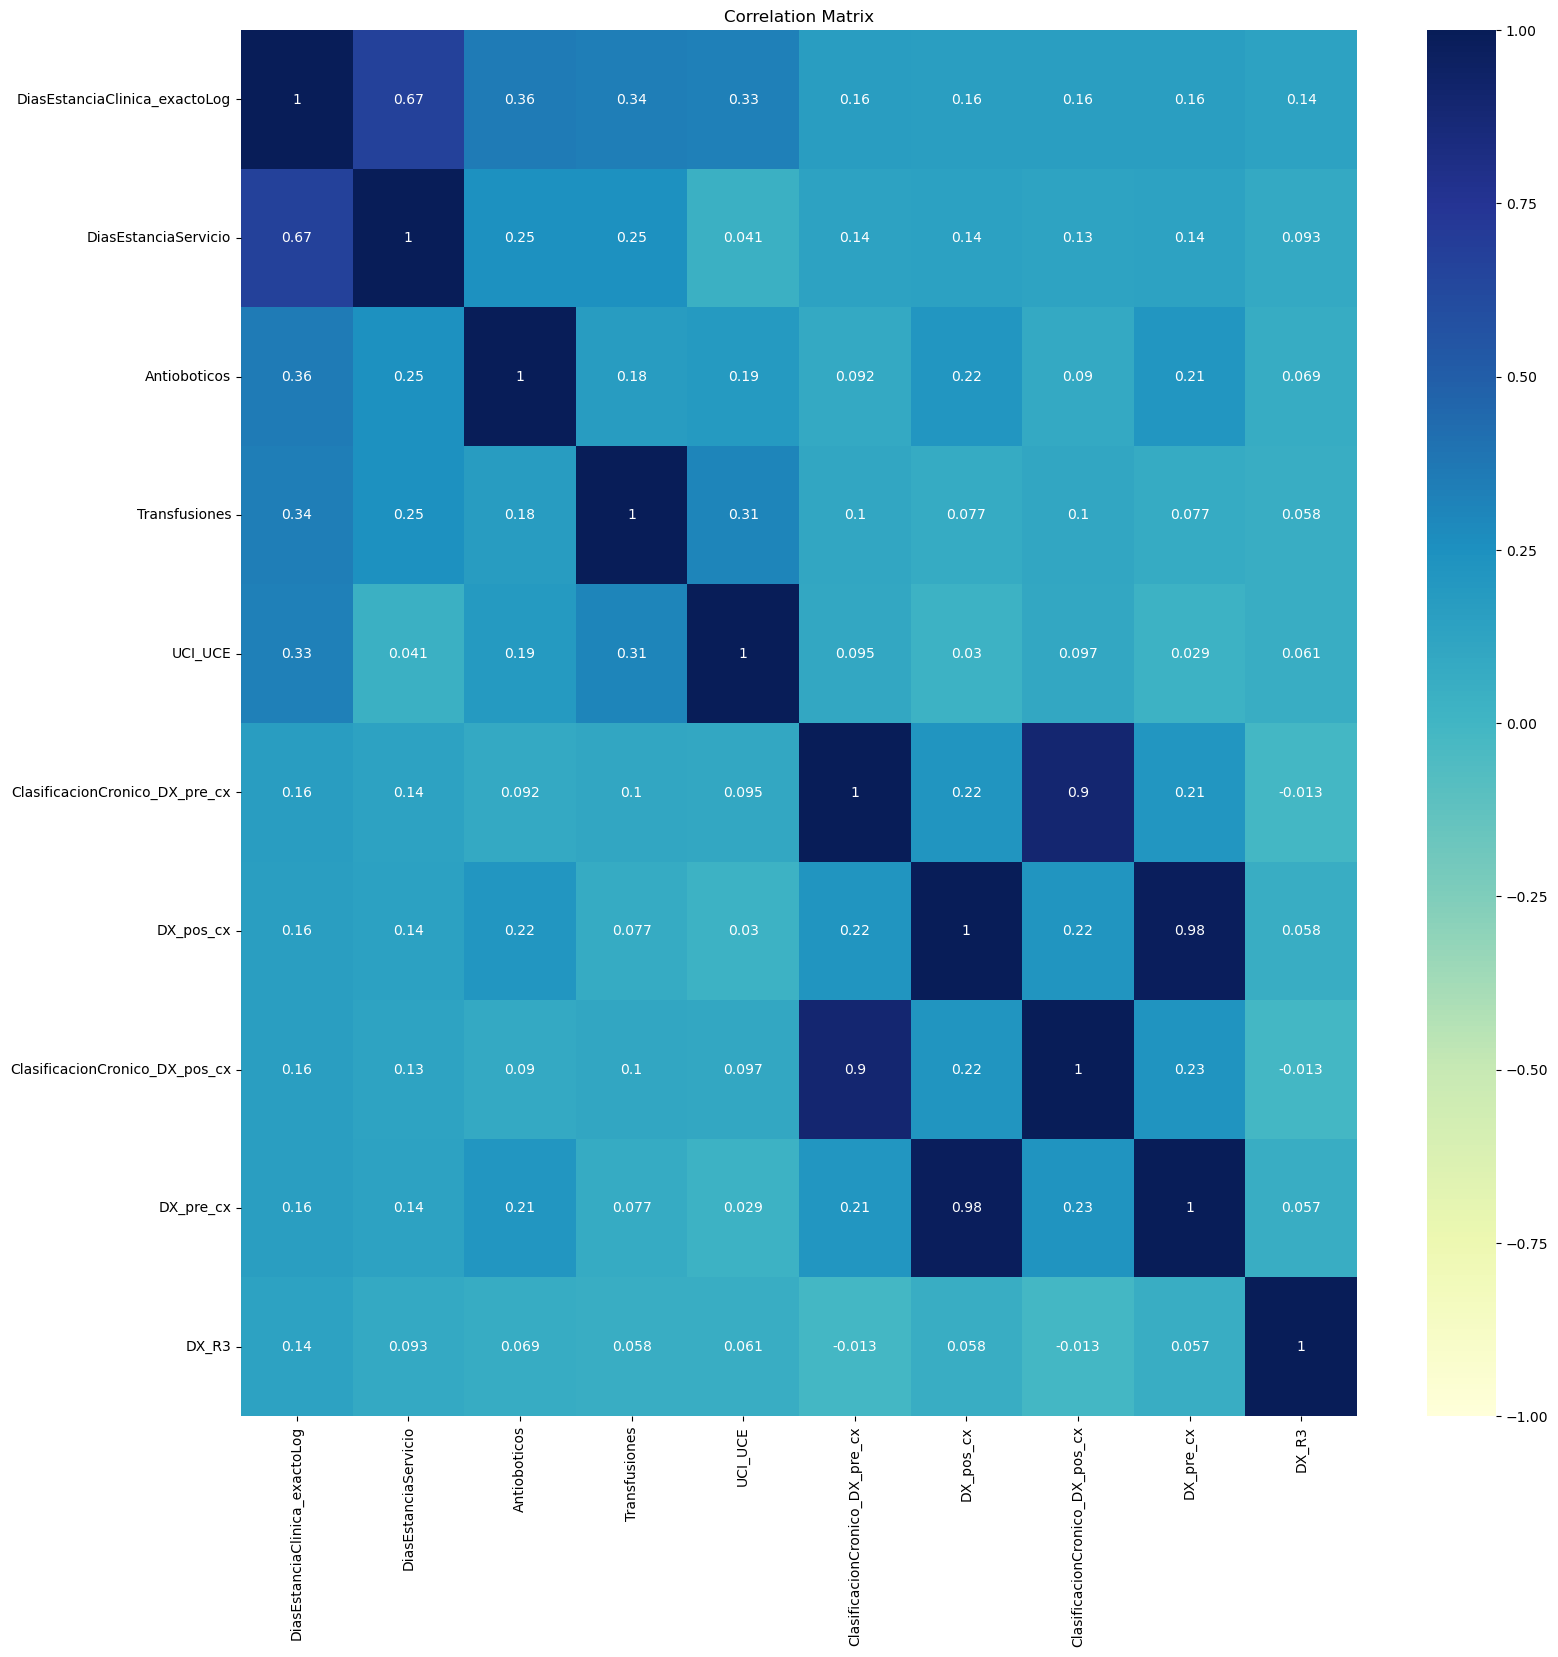

In [7]:
corr_matrix = dataset.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [8]:
target_corr_df = pd.DataFrame(corr_matrix["DiasEstanciaClinica_exactoLog"].sort_values(ascending=False))
target_corr_df 

,DiasEstanciaClinica_exactoLog
DiasEstanciaClinica_exactoLog,1.000000
DiasEstanciaServicio,0.671309
Antioboticos,0.357724
Transfusiones,0.337105
UCI_UCE,0.334056
ClasificacionCronico_DX_pre_cx,0.164079
DX_pos_cx,0.161087
ClasificacionCronico_DX_pos_cx,0.160747
DX_pre_cx,0.158057
DX_R3,0.137918


## 0.2 Métricas

En este caso se usara el RMSE, debido a su validez y uso para problemas de regresión, adicionalmente se construye un data frame con MAE, MSE, R2 y los ratios de MAE y RMSE, para su comparación final

In [9]:
x=dataset.drop(["DiasEstanciaClinica_exactoLog"],axis=1)
y=dataset["DiasEstanciaClinica_exactoLog"].values

En los casos anteriores se puede observar que los modelos obtienen mejores resultados dependiendo de la cantidad de datos, pero esto indicaría tener que adicionar muchos datos lo cual resultaría en un costo computacional elevado, para ello entonces se buscara un punto de equilibrio con la sección del código 0.1

# 2. Métodos supervisados

Métrica

In [10]:
def train_test_evaluate(model_name, model, X_train, y_train, X_test, y_test):  
    
    y_pred= model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    r2 = r2_score(y_test, y_pred)
    y_test_mean= y_test.mean()
    mae_ratio= mae/y_test_mean
    rmse_ratio= rmse/y_test_mean
    
    result_df = pd.DataFrame(
        data=[[model_name, mae, mse, rmse, r2, mae_ratio, rmse_ratio]], 
        columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"])
    return result_df

In [11]:
def report_cv_score(z):
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [12]:

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
scaler=StandardScaler()
Xtv=scaler.fit_transform(Xtv)
Xts=scaler.fit_transform(Xts)
print (Xtv.shape, Xts.shape)

(43154, 9) (43154,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(30207, 9) (12947, 9)


### 2.1 Mejor estimador:

In [18]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [21]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
names=["LinearRegression inicial","DecisisionTree inicial","Random Forest inicial","LinearSVR inicial"]
for i in range(len(estimators)):
    print("---------")
    z = cross_validate(estimators[i], Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
    if i==0:
        estimators[i].fit(Xtv, ytv)
        result_df= train_test_evaluate(names[i], estimators[i], Xtv, ytv, Xts, yts)
    else:
        estimators[i].fit(Xtv, ytv)
        df1=train_test_evaluate(names[i], estimators[i], Xtv, ytv, Xts, yts)
        result_df=pd.concat([result_df,df1],ignore_index=True)

    
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSE Test:  0.66528 (± 0.00672819 )
RMSE Train:  0.66533 (± 0.00502649 )
---------
RMSE Test:  0.53487 (± 0.00829330 )
RMSE Train:  0.52753 (± 0.00646048 )
---------
RMSE Test:  0.52912 (± 0.00606254 )
RMSE Train:  0.52756 (± 0.00448760 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


In [22]:
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,LinearRegression inicial,0.467760,0.424102,0.651231,0.584843,0.277000,0.385648
1,DecisisionTree inicial,0.338282,0.270338,0.519940,0.735363,0.200325,0.307900
2,Random Forest inicial,0.337040,0.269596,0.519226,0.736090,0.199589,0.307477


In [23]:
best_estimator

RandomForestRegressor(max_depth=5, n_estimators=2)

Así seleccionamos como mejor estimador Random Forest y procedemos a seleccionar los mejores hiperparámetros

### 2.2 RandomForest

In [24]:
#Esta celda toma un tiempo considerable en completarse
parametros = {
    "n_estimators": list(range(20, 61, 20)),
    "max_depth": list(range(11, 20, 2)),
    "min_samples_leaf": list(range(1, 3)),
    "random_state": [23]
}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs=-1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=23; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [25]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 60, 'random_state': 23}


In [26]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                   random_state=forest_reg.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

In [27]:
print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))

RMSE del Random Forest en entrenamiento:  0.44581
RMSE del Random Forest seleccionado:  0.50117


In [28]:
df1=train_test_evaluate("Mejor Random Forest", Rdm_forest, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)

### 2.3 Adición de modelos

En este caso se sabe que el mejor modelo en este caso es random forest, pero para hacer una comparación justa se mejoran los hiperpárametros de los otros estimadores para tener un mejor criterio

In [30]:
parametros_destree = {'max_depth': [2,5,8,12,15,20,30,40,50]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros_destree,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        n_jobs = -1)
decission_tree.fit(Xtv,ytv)
print("Mejores parámetros para Desission tree: ", decission_tree.best_params_)
Des_tree = DecisionTreeRegressor(max_depth=decission_tree.best_params_["max_depth"])
Des_tree.fit(Xtv, ytv)
df1=train_test_evaluate("Mejor Decision Tree", Des_tree, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)



Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores parámetros para Desission tree:  {'max_depth': 8}


## 3 Metodos no supervisados

### 3.1 PCA

In [31]:

components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf_pca = [] 
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"]
                                   ,random_state=forest_reg.best_params_["random_state"])
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(x)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    Rdm_forest.fit(Xtv, ytv)
    perf_pca.append(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))
    print('------------')
    
print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_pca)),'  ; obtenido con ',components[np.argmin(perf_pca)],' componentes para PCA')
    

(30207, 1) (12947, 1)
RMSE del modelo con  1 elementos:  0.87512
------------
(30207, 3) (12947, 3)
RMSE del modelo con  3 elementos:  0.75737
------------
(30207, 5) (12947, 5)
RMSE del modelo con  5 elementos:  0.56323
------------
(30207, 7) (12947, 7)
RMSE del modelo con  7 elementos:  0.50690
------------
(30207, 9) (12947, 9)
RMSE del modelo con  9 elementos:  0.51392
------------
Mejor RMSE:  0.50690   ; obtenido con  7  componentes para PCA


### 3.1.1 PCA+RandomForest

In [32]:
#MEJOR PCA
pca = PCA(n_components = components[np.argmin(perf_pca)])
X_t1 = pca.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(30207, 7) (12947, 7)


In [33]:
#Nota: Correr esta celda toma un tiempo considerable
forest_reg_pca = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)
forest_reg_pca.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.1s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   1.1s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.2s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.2s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.2s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.3s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   1.2s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   1.1s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=23; total time=   2.3s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=2

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [34]:
print("Mejor estimador Random Forest: ",forest_reg_pca.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg_pca.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 60, 'random_state': 23}


In [35]:
#Mejor random forest para el PCA obtenido
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg_pca.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg_pca.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg_pca.best_params_["min_samples_leaf"],
                                   random_state=forest_reg_pca.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

In [36]:
#Desempeño del modelo Random Forest seleccionado
print('RMSE Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))

RMSE Random Forest en entrenamiento:  0.44533
RMSE del Random Forest seleccionado:  0.50925


In [37]:
df1=train_test_evaluate("Mejor Random Forest+PCA", Rdm_forest, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)

### 3.1.2 PCA+Decision Tree

In [38]:
perf_pca_des = [] 
Des_tree = DecisionTreeRegressor(max_depth=decission_tree.best_params_["max_depth"])
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(x)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    Des_tree.fit(Xtv, ytv)
    perf_pca_des.append(mean_squared_error(yts , Des_tree.predict(Xts),squared=False))
print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_pca_des)),
        '  ; obtenido con ',components[np.argmin(perf_pca_des)],' componentes para PCA')
pca = PCA(n_components = components[np.argmin(perf_pca_des)])
X_t1 = pca.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
decission_tree_pca = GridSearchCV(estimator = estimator2,
                        param_grid = parametros_destree,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)
decission_tree_pca.fit(Xtv, ytv)
Des_tree = DecisionTreeRegressor(max_depth=decission_tree_pca.best_params_["max_depth"])
Des_tree.fit(Xtv,ytv)
df1=train_test_evaluate("Mejor Decision Tree+PCA", Des_tree, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)


(30207, 1) (12947, 1)
(30207, 3) (12947, 3)
(30207, 5) (12947, 5)
(30207, 7) (12947, 7)
(30207, 9) (12947, 9)
Mejor RMSE:  0.52854   ; obtenido con  7  componentes para PCA
(30207, 7) (12947, 7)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.1s
[CV] END ........................................max_depth=5; total time=   0.1s
[CV] END .......

### 3.2 NMF

Primeramente eliminamos las columnas con valores negativos

In [39]:
numeric_columns = x.select_dtypes(include=[np.number])
negative_columns = numeric_columns.columns[numeric_columns.lt(0).any()]
x2=x.drop(negative_columns,axis=1)

In [40]:

test_size = 0.3
val_size  = test_size/(1-test_size)
perf_nmf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                   random_state=forest_reg.best_params_["random_state"])
for i in components:
    nmf = NMF(n_components = i,max_iter=1000)
    X_t = nmf.fit_transform(x2)
    
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf_nmf.append(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))
    print('------------')

print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_nmf)),'  ; obtenido con ',components[np.argmin(perf_nmf)],' componentes para NMF')

/home/astolfo/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


(30207, 1) (12947, 1)
RMSE del modelo con  1 elementos:  0.87370
------------
(30207, 3) (12947, 3)
RMSE del modelo con  3 elementos:  0.70668
------------
(30207, 5) (12947, 5)
RMSE del modelo con  5 elementos:  0.63798
------------
(30207, 7) (12947, 7)
RMSE del modelo con  7 elementos:  0.61612
------------
(30207, 9) (12947, 9)
RMSE del modelo con  9 elementos:  0.61571
------------
Mejor RMSE:  0.61571   ; obtenido con  9  componentes para NMF


In [41]:
#MEJOR NMF
test_size = 0.3
val_size  = test_size/(1-test_size)
nmf = NMF(n_components = components[np.argmin(perf_nmf)])
X_t2 = nmf.fit_transform(x2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(30207, 9) (12947, 9)


### 3.2.1 NMF+RandomForest

In [42]:
forest_reg_nmf = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)
forest_reg_nmf.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.6s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=23; total time=   1.3s[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.6s

[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=23; total time=   1.3s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=2

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [43]:
print("Mejor estimador Random forest: ",forest_reg_nmf.best_estimator_)
print("Mejores parámetros para Random forest: ", forest_reg_nmf.best_params_)

Mejor estimador Random forest:  RandomForestRegressor(max_depth=17, min_samples_leaf=2, n_estimators=60,
                      random_state=23)
Mejores parámetros para Random forest:  {'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 60, 'random_state': 23}


In [44]:
#Mejor Decision Tree para el NMF obtenido
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg_nmf.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg_nmf.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg_nmf.best_params_["min_samples_leaf"],
                                   random_state=forest_reg_nmf.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=17, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

In [45]:
print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Fores seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))

RMSE del Random Forest en entrenamiento:  0.43028
RMSE del Random Fores seleccionado:  0.60059


In [46]:
df1=train_test_evaluate("Mejor Random Forest+NMF", Rdm_forest, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)

### 3.2.2 NFM+Decision Tree

In [47]:
perf_nmf_des = [] 
Des_tree = DecisionTreeRegressor(max_depth=decission_tree.best_params_["max_depth"])
for i in components:
    nmf = NMF(n_components = i,max_iter=500)
    X_t = nmf.fit_transform(x2)
    
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf_nmf_des.append(mean_squared_error(yts , Des_tree.predict(Xts),squared=False))
nmf = NMF(n_components = components[np.argmin(perf_nmf_des)])
X_t2 = nmf.fit_transform(x2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
decission_tree_nmf = GridSearchCV(estimator = estimator2,
                        param_grid = parametros_destree,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)
decission_tree_nmf.fit(Xtv, ytv)
Des_tree = DecisionTreeRegressor(max_depth=decission_tree_nmf.best_params_["max_depth"])
Des_tree.fit(Xtv,ytv)
df1=train_test_evaluate("Mejor Decision Tree+NFM", Des_tree, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)

/home/astolfo/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


(30207, 1) (12947, 1)
(30207, 3) (12947, 3)
(30207, 5) (12947, 5)
(30207, 7) (12947, 7)
(30207, 9) (12947, 9)
(30207, 7) (12947, 7)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................................max_depth=2; total time=   0.0s[CV] END ........................................max_depth=2; total time=   0.0s

[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s[CV] END ........................................max_depth=5; total time=   0.0s

[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0

In [48]:
result_df.to_csv("Results.csv",index=False)

In [49]:
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,LinearRegression inicial,0.467760,0.424102,0.651231,0.584843,0.277000,0.385648
1,DecisisionTree inicial,0.338282,0.270338,0.519940,0.735363,0.200325,0.307900
2,Random Forest inicial,0.337040,0.269596,0.519226,0.736090,0.199589,0.307477
3,Mejor Random Forest,0.321205,0.251174,0.501172,0.754124,0.190212,0.296786
4,Mejor Decision Tree,0.331686,0.265257,0.515031,0.740338,0.196419,0.304993
5,Mejor Decision Tree,0.331665,0.265245,0.515020,0.740349,0.196406,0.304986
6,Mejor Random Forest+PCA,0.326481,0.259337,0.509251,0.745207,0.193704,0.302144
7,Mejor Decision Tree+PCA,0.353565,0.290087,0.538598,0.720856,0.210217,0.320231
8,Mejor Random Forest+NMF,0.396567,0.360710,0.600592,0.657204,0.233524,0.353667
9,Mejor Decision Tree+NFM,0.484078,0.468384,0.684386,0.540742,0.287297,0.406178


# 4. Curvas de aprendizaje

Para conocer el valor de datos necesarios para entrenar un buen modelo, o ver como responden los diferentes algoritmos a la cantidad de datos de este problema, se realizaran curvas para observar su comportamiento y así evaluar si se necesita agregar más datos

## 4.1 Método supervisado

In [50]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

En este caso lo hacemos con Random Forest debido a que fue el modelo con mejor desempeño, general

In [51]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(43154, 9) (43154,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(30207, 9) (12947, 9)


In [52]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"]
                                    ,max_depth = forest_reg.best_params_["max_depth"]
                                    ,min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                    random_state=forest_reg.best_params_["random_state"])

### 4.1.1 Random Forest

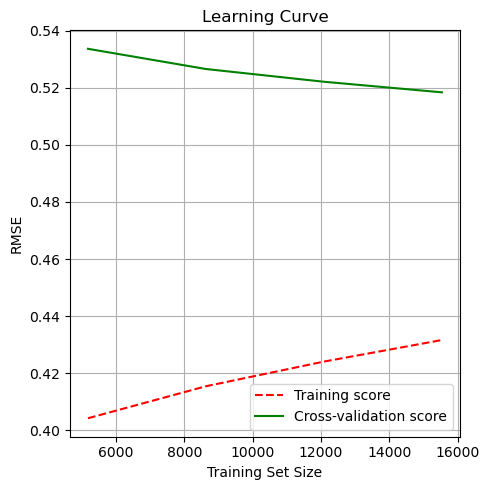

<module 'matplotlib.pyplot' from '/home/astolfo/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [53]:
lc_plot(Rdm_forest,Xtv,ytv)

## 4.2 Métodos no supervisados

### 4.2.1 Random Forest y PCA

In [54]:
pca = PCA(n_components = components[np.argmin(perf_pca)])
X_t1 = pca.fit_transform(x)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg_pca.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg_pca.best_params_["max_depth"]
                                   ,min_samples_leaf=forest_reg_pca.best_params_["min_samples_leaf"],
                                   random_state=forest_reg_pca.best_params_["random_state"])

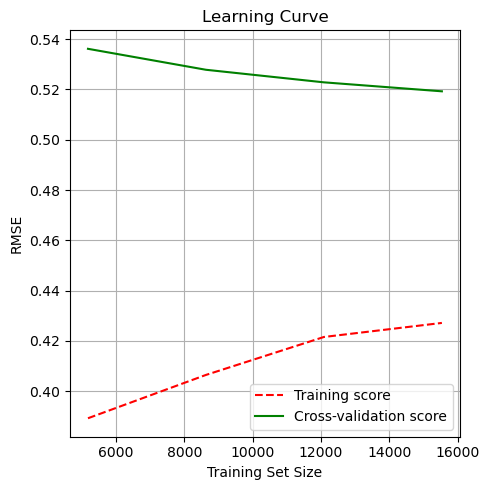

<module 'matplotlib.pyplot' from '/home/astolfo/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [55]:
lc_plot(Rdm_forest,Xtv,ytv)

### 4.2.2 NMF y Random Forest

In [58]:
nmf = NMF(n_components = components[np.argmin(perf_nmf)])
X_t2 = nmf.fit_transform(x2)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg_nmf.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg_nmf.best_params_["max_depth"]
                                   ,min_samples_leaf=forest_reg_nmf.best_params_["min_samples_leaf"],
                                   random_state=forest_reg_nmf.best_params_["random_state"])

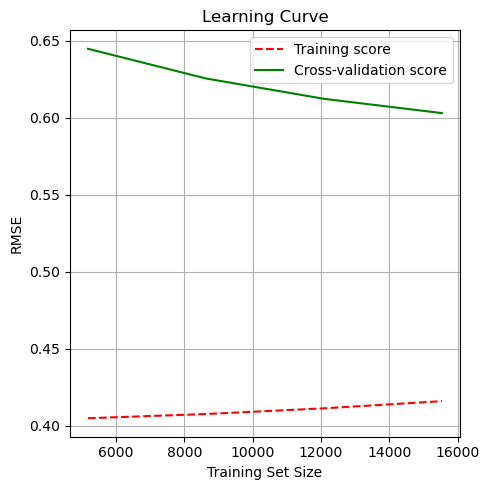

<module 'matplotlib.pyplot' from '/home/astolfo/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [59]:
lc_plot(Rdm_forest,Xtv,ytv)

# 5 Análisis de resultados

## 5.1 Modelo con mejor desenseño general 

In [60]:
result_df_copy=result_df.copy()

In [61]:
result_df=result_df.sort_values("RMSE Ratio",ignore_index=True)
heat_result=result_df.set_index("Model")
heat_result["Neg R2 Score"]=-heat_result["R2 Score"]
heat_result=heat_result[['MAE', 'MSE', 'RMSE', 'Neg R2 Score', 'MAE Ratio', 'RMSE Ratio']]
scaler=MinMaxScaler((0,100))
heat_result_scaled=scaler.fit_transform(heat_result)
heat_result=pd.DataFrame(heat_result_scaled,index=heat_result.index,columns=heat_result.columns)

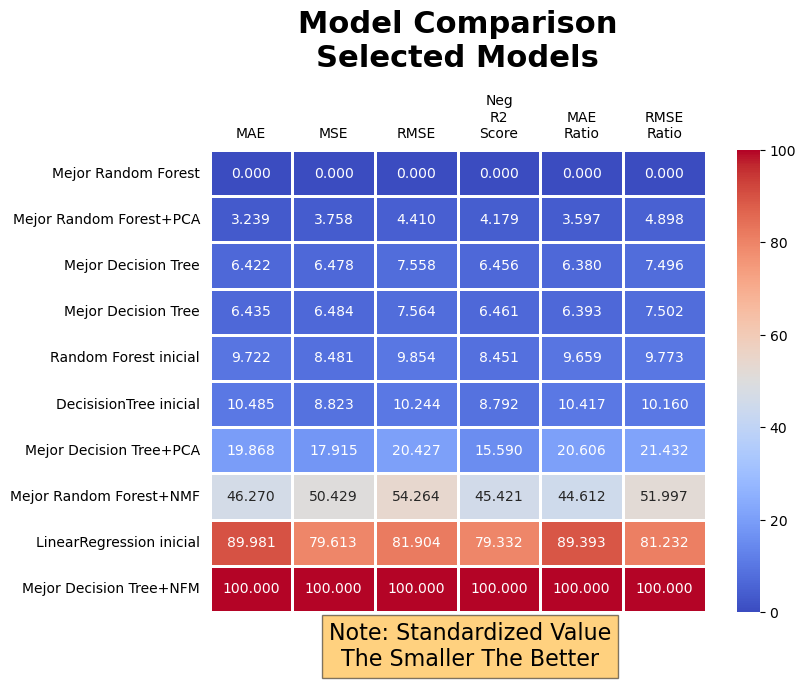

In [62]:
plt.figure(figsize= (8, 6))
cmap=sns.color_palette("coolwarm",as_cmap=True)
ax= sns.heatmap(heat_result, annot=True, fmt=".3f", cmap=cmap, linewidths= 1)

ax.xaxis.tick_top()
ax.set_xticklabels([textwrap.fill(e, 5) for e in heat_result.columns])
ax.tick_params(left=False, top=False)

plt.title("Model Comparison\nSelected Models", fontsize= 22, fontweight= "bold", pad= 20)
plt.figtext(0.45, 0.02, "Note: Standardized Value\nThe Smaller The Better", ha="center", fontsize= 16, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.ylabel("")

plt.show()

In [65]:
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,Mejor Random Forest,0.321205,0.251174,0.501172,0.754124,0.190212,0.296786
1,Mejor Random Forest+PCA,0.326481,0.259337,0.509251,0.745207,0.193704,0.302144
2,Mejor Decision Tree,0.331665,0.265245,0.515020,0.740349,0.196406,0.304986
3,Mejor Decision Tree,0.331686,0.265257,0.515031,0.740338,0.196419,0.304993
4,Random Forest inicial,0.337040,0.269596,0.519226,0.736090,0.199589,0.307477
5,DecisisionTree inicial,0.338282,0.270338,0.519940,0.735363,0.200325,0.307900
6,Mejor Decision Tree+PCA,0.353565,0.290087,0.538598,0.720856,0.210217,0.320231
7,Mejor Random Forest+NMF,0.396567,0.360710,0.600592,0.657204,0.233524,0.353667
8,LinearRegression inicial,0.467760,0.424102,0.651231,0.584843,0.277000,0.385648
9,Mejor Decision Tree+NFM,0.484078,0.468384,0.684386,0.540742,0.287297,0.406178


## 5.1.1 Exportar el modelo

In [67]:
Rdm_forest

RandomForestRegressor(max_depth=17, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

In [68]:
joblib.dump(Rdm_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [69]:
load_randomForest=joblib.load("random_forest_model.pkl")

In [70]:
load_randomForest

RandomForestRegressor(max_depth=17, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

## 5.2 Tablas de los mejores hiperparametros para cada situación

### 5.2.1 Random Forest

In [63]:
index_name=["Best Random Forest","Best Random Forest+PCA","Best Random Forest+NMF"]
dicts=[forest_reg.best_params_,forest_reg_pca.best_params_,forest_reg_nmf.best_params_]
best_hiper_random=pd.DataFrame(dicts,index=index_name)
best_hiper_random

,max_depth,min_samples_leaf,n_estimators,random_state
Best Random Forest,11,2,60,23
Best Random Forest+PCA,11,2,60,23
Best Random Forest+NMF,17,2,60,23


### 5.2.2 Decision Tree

In [64]:
index_name=["Best Decision Tree","Best Decision Tree+PCA","Best Decision Tree+NMF"]
dicts=[decission_tree.best_params_,decission_tree_pca.best_params_,decission_tree_nmf.best_params_]
best_hiper_random=pd.DataFrame(dicts,index=index_name)
best_hiper_random

,max_depth
Best Decision Tree,8
Best Decision Tree+PCA,8
Best Decision Tree+NMF,8
